### Load package

In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import random
from sklearn.utils import shuffle
import spacy
import string
from spacy.matcher import Matcher
from spacy.tokens import Token

### Load data and preprocessing

In [3]:
def create_df(path,label):
    filelist = os.listdir(path)
    df = pd.DataFrame(columns=['Review','Label'])
    for infile in filelist:
        file = os.path.join(path,infile)
        lines = open(file).read()
        df = df.append({'Review': lines,'Label': label}, ignore_index=True)
        
    return df

train_neg = create_df('aclImdb/train/neg',0)
train_pos = create_df('aclImdb/train/pos',1)
test_neg =  create_df('aclImdb/test/neg',0)
test_pos = create_df('aclImdb/test/pos',1)

In [4]:
# Merge the neg and pos review and shuffle 
train = shuffle(train_neg.append(train_pos),random_state=0)\
.reset_index(drop=True)
test = shuffle(test_neg.append(test_pos),random_state=0)\
.reset_index(drop=True)


# Split train data into actual train and validation sets

train_split = 20000
train_data = list(train.Review[:train_split])
train_data = [s.replace( '<br />','\n') for s in train_data]
train_targets = np.array(train.Label[:train_split])
                         
val_data = list(train.Review[train_split:])
val_data = [s.replace( '<br />','\n') for s in val_data]
val_targets = np.array(train.Label[train_split:])
                       
test_data = list(test.Review)
test_data = [s.replace( '<br />','\n') for s in test_data]
test_targets = np.array(test.Label)


In [4]:
# overview of the class distribution in each data set

print ("Train dataset size is {}; \nThere are {} positive examples and {} negative examples \
in the train dataset; \n{}% of Train data is positive.".format(len(train_data),\
                                                               np.count_nonzero(train_targets == 1),\
                                                               np.count_nonzero(train_targets == 0),\
                                                               (np.count_nonzero(train_targets == 1)/len(train_data))*100))
print ("\nVal dataset size is {}; \nThere are {} positive examples and {} negative examples \
in the validation dataset; \n{}% of validation data is positive.".format(len(val_data),\
                                                                         np.count_nonzero(val_targets == 1),\
                                                                         np.count_nonzero(val_targets == 0),\
                                                                         (np.count_nonzero(val_targets == 1)/len(val_data))*100))

print ("\nTest dataset size is {}; \nThere are {} positive examples and {} negative examples \
in the test dataset; \n{}% of test data is positive.".format(len(test_data),\
                                                             np.count_nonzero(test_targets == 1),\
                                                             np.count_nonzero(test_targets == 0),\
                                                             (np.count_nonzero(test_targets == 1)/len(test_data))*100))

# Random sample from train dataset
import random
print(train_data[random.randint(0, len(train_data) - 1)])

Train dataset size is 20000; 
There are 9992 positive examples and 10008 negative examples in the train dataset; 
49.96% of Train data is positive.

Val dataset size is 5000; 
There are 2508 positive examples and 2492 negative examples in the validation dataset; 
50.160000000000004% of validation data is positive.

Test dataset size is 25000; 
There are 12500 positive examples and 12500 negative examples in the test dataset; 
50.0% of test data is positive.
i'm really getting old,,am in the midst of watching this 40 year old flick,and wonder what my grandchildren will be watching 40 years from now,,its an old saying,,but they don't make em like that anymore..it's not only the story,its the music,the acting both by young and old..the cast ,it would seem,were born to play their roles,,young oliver,,old Fagin..too many to mention them all,the role played by the judge oliver stands before,i've seen in other roles over the years..the artful dodger,,Ron moody as Fagin,,Mr and Mrs bumble,,the

## 1. Tokenization Schema V.S. model performance 
(Parameter configuration: uni-gram/vocabulary size 10000/embedding size )
 - Keep punctuation and upper case. 
 - Throw punctuation and upper case.
 - remove stop words 


### 1.1 Load the tokenizer from NLTK and define functions for different tokenization schema

In [138]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
stop_words = tokenizer.Defaults.stop_words
# remove the negation which can change the attitude in a sentence
whitelist = {'cannot','neither','never',\
 'nevertheless',\
 'next',
 'nine',
 'no',
 'nobody',
 'none',
 'noone',
 'nor',
 'not',
 'nothing','nowhere','unless'}
stop_words -= whitelist
len(stop_words)

290

In [259]:
# Just spliting by space and keep all punctuations and uppercase
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import re

def tokenize0(sent):
  tokens = word_tokenize(sent)
  return [token for token in tokens ]


# lowercase and remove punctuation
def tokenize1(sent):
  tokens = word_tokenize(sent)
  return [token.lower() for token in tokens if ((token not in punctuations) & (token not in '\n\n\n\n\n\n\n'))]

def tokenize2(sent):
  tokens = word_tokenize(sent)
  return [token.lower() for token in tokens if ((token not in punctuations) & (token not in '\n\n\n\n\n\n\n') &(token not in stop_words ))]
from nltk.stem import PorterStemmer, WordNetLemmatizer
wnl = WordNetLemmatizer()
def tokenize3(sent):
    tokens = word_tokenize(sent)
    return " ".join([wnl.lemmatize(token) for token in tokens if ((token not in punctuations) & (token not in '\n\n\n\n\n\n\n'))])
def tokenize_dataset_schema(schema_func, dataset):
    ### Token part(token scheme & n-grams)
    # val set tokens
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
            tokens = schema_func(sample)
            token_dataset.append(tokens)
            all_tokens += tokens

    return token_dataset, all_tokens 


### 1.2  Import the func for the rest parts after token
#Almost same as the code in the lab3

In [274]:
## Build vocabulary(vocab size)
from collections import Counter

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [275]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [276]:
# one of the hyper para for bow max_sentence_length(recommend values:80% of the maximum length )
MAX_SENTENCE_LENGTH = 400

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        # here we just cutted the length of review to 400.
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    #datum[0]: the token vector for each review ; datum[1]: the length of tokens; datum[2]:the label 
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    # the pad_width is to add 0's to the end of token vectors to make sure each review with same length
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [277]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx # 
        # at least 100 for emb_dim
        # the padding_idx here means when encounter the index 0, 
        #just keep it as 0 instead of embedding it to non-0 vectors
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        #two classes here
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        # sum vertically 400*100 -------1*100
        out = torch.sum(out, dim=1)
        # average 
        # tensor.view: see sensors in one column
        # expand each length to a 1*100 vector for / operation 
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [278]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)#compute the probalities
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


### 1.3 Tuning schema function and run

In [289]:
def schema_tuning(schema_func):
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset_schema(schema_func, val_data)
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset_schema(schema_func,train_data)
    #Build_vocabulary
    max_vocab_size = 10000
    token2id, id2token = build_vocab(all_train_tokens,max_vocab_size)
    ### Convert token to the id in the dataset
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)

    ### Dataloader (batch size & max_sentence_len)
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    ### call the BOW models(emb_dim, padding_index)
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)
    ### Training the model (lr, optimizer, criterion)
    learning_rate = 0.01
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_loss = []
    epoch_val_acc = []
    val_ls = []
    for epoch in range(num_epochs):
        loss_ls = []
        
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss_ls.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_ls.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
        print('Epoch: [{}/{}], Traning loss: {}'.format(epoch+1, num_epochs,sum(loss_ls)))
        epoch_loss.append(sum(loss_ls).item())
        epoch_val_acc.append(test_model(val_loader, model))
    ### Get the test acc
    print ("After training for {} epochs".format(num_epochs))
    print ("For schema {}, Val Acc {}".format(schema_func,test_model(val_loader, model)))
    val_acc = test_model(val_loader, model)
    return epoch_loss, epoch_val_acc,val_acc, val_ls

In [280]:
schema0_epoch_loss, schema0_epoch_val,schema0_val_acc, schema0_val_ls = schema_tuning(tokenize0)

Tokenizing val data
Tokenizing train data
Epoch: [1/10], Step: [101/625], Validation Acc: 81.9
Epoch: [1/10], Step: [201/625], Validation Acc: 86.06
Epoch: [1/10], Step: [301/625], Validation Acc: 87.28
Epoch: [1/10], Step: [401/625], Validation Acc: 87.94
Epoch: [1/10], Step: [501/625], Validation Acc: 87.4
Epoch: [1/10], Step: [601/625], Validation Acc: 88.4
Epoch: [1/10], Traning loss: 225.32806396484375
Epoch: [2/10], Step: [101/625], Validation Acc: 89.24
Epoch: [2/10], Step: [201/625], Validation Acc: 88.6
Epoch: [2/10], Step: [301/625], Validation Acc: 88.48
Epoch: [2/10], Step: [401/625], Validation Acc: 88.72
Epoch: [2/10], Step: [501/625], Validation Acc: 88.54
Epoch: [2/10], Step: [601/625], Validation Acc: 88.3
Epoch: [2/10], Traning loss: 122.93684387207031
Epoch: [3/10], Step: [101/625], Validation Acc: 88.28
Epoch: [3/10], Step: [201/625], Validation Acc: 87.86
Epoch: [3/10], Step: [301/625], Validation Acc: 87.26
Epoch: [3/10], Step: [401/625], Validation Acc: 87.8
Epoc

In [288]:
schema1_epoch_loss, schema1_epoch_val,schema1_val_acc, schema1_val_ls = schema_tuning(tokenize1)

Tokenizing val data
Tokenizing train data
Epoch: [1/10], Step: [101/625], Validation Acc: 81.32
Epoch: [1/10], Step: [201/625], Validation Acc: 82.96
Epoch: [1/10], Step: [301/625], Validation Acc: 86.6
Epoch: [1/10], Step: [401/625], Validation Acc: 87.28
Epoch: [1/10], Step: [501/625], Validation Acc: 88.3
Epoch: [1/10], Step: [601/625], Validation Acc: 88.04
Epoch: [1/10], Traning loss: 227.81204223632812
Epoch: [2/10], Step: [101/625], Validation Acc: 87.8
Epoch: [2/10], Step: [201/625], Validation Acc: 88.18
Epoch: [2/10], Step: [301/625], Validation Acc: 87.92
Epoch: [2/10], Step: [401/625], Validation Acc: 88.02
Epoch: [2/10], Step: [501/625], Validation Acc: 87.82
Epoch: [2/10], Step: [601/625], Validation Acc: 88.06
Epoch: [2/10], Traning loss: 141.77293395996094
Epoch: [3/10], Step: [101/625], Validation Acc: 88.0
Epoch: [3/10], Step: [201/625], Validation Acc: 88.18
Epoch: [3/10], Step: [301/625], Validation Acc: 87.5
Epoch: [3/10], Step: [401/625], Validation Acc: 87.36
Epo

In [302]:
schema2_epoch_loss, schema2_epoch_val,schema2_val_acc, schema2_val_ls = schema_tuning(tokenize2)

Tokenizing val data
Tokenizing train data
Epoch: [1/10], Step: [101/625], Validation Acc: 83.82
Epoch: [1/10], Step: [201/625], Validation Acc: 85.74
Epoch: [1/10], Step: [301/625], Validation Acc: 87.76
Epoch: [1/10], Step: [401/625], Validation Acc: 87.74
Epoch: [1/10], Step: [501/625], Validation Acc: 87.22
Epoch: [1/10], Step: [601/625], Validation Acc: 88.24
Epoch: [1/10], Traning loss: 222.65432739257812
Epoch: [2/10], Step: [101/625], Validation Acc: 88.1
Epoch: [2/10], Step: [201/625], Validation Acc: 87.84
Epoch: [2/10], Step: [301/625], Validation Acc: 88.06
Epoch: [2/10], Step: [401/625], Validation Acc: 87.66
Epoch: [2/10], Step: [501/625], Validation Acc: 88.04
Epoch: [2/10], Step: [601/625], Validation Acc: 87.4
Epoch: [2/10], Traning loss: 136.2072296142578
Epoch: [3/10], Step: [101/625], Validation Acc: 87.94
Epoch: [3/10], Step: [201/625], Validation Acc: 87.54
Epoch: [3/10], Step: [301/625], Validation Acc: 87.64
Epoch: [3/10], Step: [401/625], Validation Acc: 87.64
E

In [ ]:
# Run different tokenization models and save results into a dataframe
schema_ls = [tokenize0, tokenize1, tokenize2, tokenize3]
schema_record = pd.DataFrame(columns=['Schema','Training-loss for 10 epoch','Val-acc for 10 epoch','Val-acc'])
for schema in schema_ls:
    epoch_loss, epoch_val,val_acc = schema_tuning(schema)
    schema_record = schema_record.append({'Schema':str(schema),'Training-loss for 10 epoch': epoch_loss,'Val-acc for 10 epoch': epoch_val, 'Val-acc':val_acc}, ignore_index=True)
    

In [191]:
# Results
schema_record

,Schema,Training-loss for 10 epoch,Val-acc for 10 epoch,Val-acc
0,<function tokenize0 at 0x141c61e18>,"[225.11752319335938, 125.88008117675781, 91.84...","[88.3, 88.66, 88.0, 87.52, 86.58, 86.2, 85.52,...",85.56
1,<function tokenize1 at 0x141c61158>,"[225.97337341308594, 138.4684600830078, 116.01...","[88.42, 87.56, 87.08, 86.84, 86.3, 86.16, 85.7...",84.82
2,<function tokenize2 at 0x143fbd598>,"[220.95269775390625, 136.59222412109375, 109.8...","[87.82, 87.8, 87.78, 86.72, 86.12, 85.78, 85.7...",84.62
3,<function tokenize3 at 0x143fbd2f0>,"[422.8408203125, 416.9983215332031, 413.932891...","[54.98, 59.92, 60.1, 59.0, 59.6, 57.44, 60.26,...",59.90


In [245]:
schema_record.to_csv('schema_record.csv')

### 1.3 Viz of results. (Training curve & Validation curve)

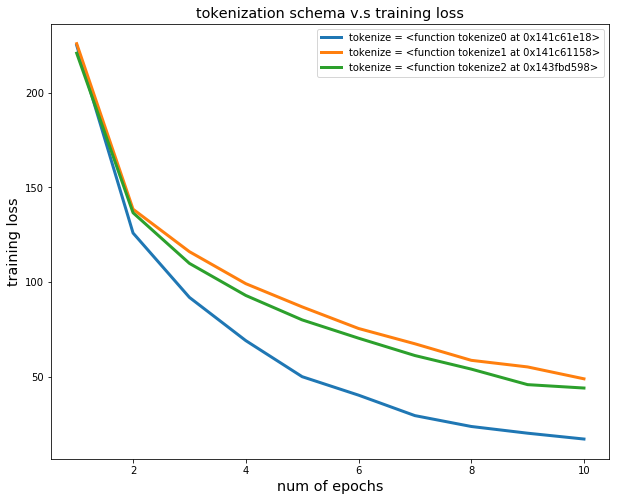

In [196]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
x = range(1,11)
for i in range(len(schema_record)-1):
    plt.plot(x,schema_record.iloc[i]['Training-loss for 10 epoch'] ,linewidth = 3,label = 'tokenize = {}'.format(schema_record.iloc[i]['Schema']))
    
plt.xlabel('num of epochs',fontsize='x-large')
plt.ylabel('training loss',fontsize='x-large')
plt.title('tokenization schema v.s training loss',fontsize='x-large')
plt.legend(loc='best')

plt.show()

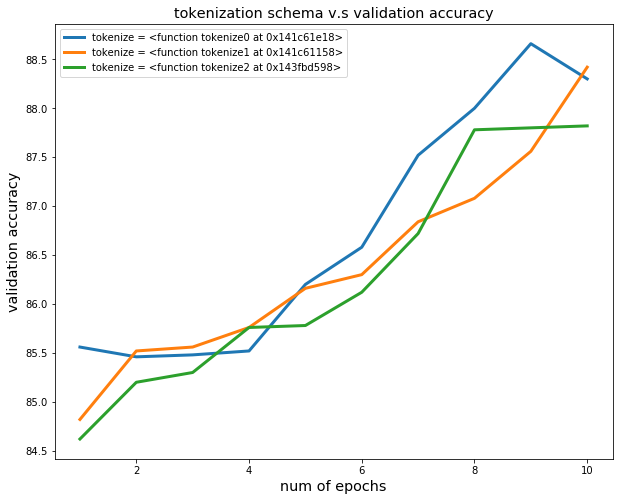

In [311]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
x = range(1,11)
for i in range(len(schema_record)-1):
    plt.plot(x,schema_record.iloc[i]['Val-acc for 10 epoch'] ,linewidth = 3,label = 'tokenize = {}'.format(schema_record.iloc[i]['Schema']))
    
plt.xlabel('num of epochs',fontsize='x-large')
plt.ylabel('validation accuracy',fontsize='x-large')
plt.title('tokenization schema v.s validation accuracy',fontsize='x-large')
plt.legend(loc='best')

plt.show()

## 2. Tune n for n-grams
- n=1: val_acc 85.96
- n=2: val_acc 81.76
- n=3: val_acc 76.86
- n=4: val_acc 72.32

In [318]:
## defince n-grams token function
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import re
def get_ngrams_tokens(text, n):
    text = text.lower()
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

def tokenize_dataset(dataset,n):
    ### Token part(token scheme & n-grams)
    # val set tokens
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
            tokens = get_ngrams_tokens(sample,n)
            token_dataset.append(tokens)
            all_tokens += tokens

    return token_dataset, all_tokens 


In [316]:
def find_best_n(n_ls):
    val_acc_ls = []
    val_epoch_arr = []
    loss_arr = []
    for n in n_ls:
        print ("Tokenizing val data")
        val_data_tokens, _ = tokenize_dataset(val_data,n)
        print ("Tokenizing train data")
        train_data_tokens, all_train_tokens = tokenize_dataset(train_data,n)
        
        ### build vocabulary 
        #max_vocab_size = 10000
        token2id, id2token = build_vocab(all_train_tokens,max_vocab_size)
        ### Convert token to the id in the dataset
        train_data_indices = token2index_dataset(train_data_tokens)
        val_data_indices = token2index_dataset(val_data_tokens)
        

        ### Dataloader (batch size & max_sentence_len)
        BATCH_SIZE = 32
        train_dataset = NewsGroupDataset(train_data_indices, train_targets)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=newsgroup_collate_func,
                                                   shuffle=True)

        val_dataset = NewsGroupDataset(val_data_indices, val_targets)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=newsgroup_collate_func,
                                                   shuffle=True)

        
        ### call the BOW models(emb_dim, padding_index)
        emb_dim = 100
        model = BagOfWords(len(id2token), emb_dim)


        ### Training the model (lr, optimizer, criterion)
        learning_rate = 0.01
        num_epochs = 10 # number epoch to train

        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print('For{}-grams--------------'.format(n))
        epoch_loss = []
        val_ls
        for epoch in range(num_epochs):
            loss_ls = []
            for i, (data, lengths, labels) in enumerate(train_loader):
                model.train()
                data_batch, length_batch, label_batch = data, lengths, labels
                optimizer.zero_grad()
                outputs = model(data_batch, length_batch)
                loss = criterion(outputs, label_batch)
                loss_ls.append(loss)
                loss.backward()
                optimizer.step()
                # validate every 100 iterations
                if i > 0 and i % 300 == 0:
                    # validate
                    val_acc = test_model(val_loader, model)
                    val_ls.append(val_acc)
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                               epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            epoch_loss.append(sum(loss_ls))
        ### Get the validation acc
        print ("After training for {} epochs".format(num_epochs))
        print ("Val Acc {}".format(test_model(val_loader, model)))
        val_acc_ls.append(test_model(val_loader, model))
        val_epoch_arr.append(val_ls)
        loss_arr.append(epoch_loss)
    best_idx = val_acc_ls.index(max(val_acc_ls))
    best_n = n_ls[best_idx]
    loss_arr = np.array(loss_arr)
    val_epoch_arr = np.array(val_epoch_arr)
    print()
    print('For hyperparameter n for n-grams, {} performs best with val acc {}'.format(best_n, max(val_acc_ls)))
    return val_acc_ls, best_n,loss_arr,val_epoch_arr

In [317]:
ngram_val_acc, ngram_n, ngram_loss_arr, ngram_val_arr = find_best_n([1,2,3,4])

Tokenizing val data
Tokenizing train data
For1-grams--------------
Epoch: [1/10], Step: [301/625], Validation Acc: 87.14
Epoch: [1/10], Step: [601/625], Validation Acc: 87.76
Epoch: [2/10], Step: [301/625], Validation Acc: 87.52
Epoch: [2/10], Step: [601/625], Validation Acc: 87.38
Epoch: [3/10], Step: [301/625], Validation Acc: 87.26
Epoch: [3/10], Step: [601/625], Validation Acc: 86.68
Epoch: [4/10], Step: [301/625], Validation Acc: 86.7
Epoch: [4/10], Step: [601/625], Validation Acc: 85.98
Epoch: [5/10], Step: [301/625], Validation Acc: 86.42
Epoch: [5/10], Step: [601/625], Validation Acc: 86.18
Epoch: [6/10], Step: [301/625], Validation Acc: 85.98
Epoch: [6/10], Step: [601/625], Validation Acc: 85.62
Epoch: [7/10], Step: [301/625], Validation Acc: 85.72
Epoch: [7/10], Step: [601/625], Validation Acc: 85.64
Epoch: [8/10], Step: [301/625], Validation Acc: 85.16
Epoch: [8/10], Step: [601/625], Validation Acc: 85.4
Epoch: [9/10], Step: [301/625], Validation Acc: 85.48
Epoch: [9/10], St

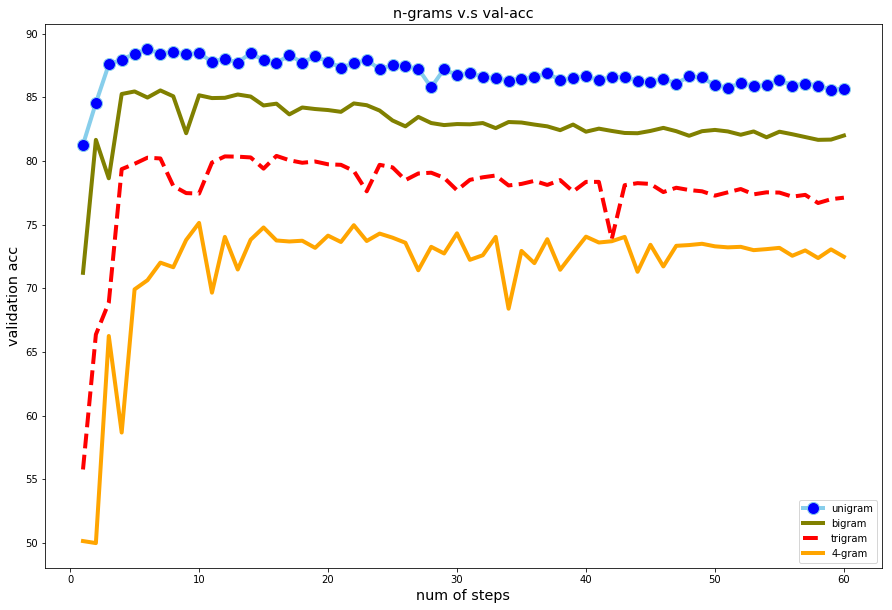

In [415]:
plt.figure(figsize=(15,10))
plt.plot( range(1,61),ngram_val_arr[0],marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'unigram')
plt.plot( range(1,61),ngram_val_arr[1], marker='', color='olive', linewidth=4,label = 'bigram')
plt.plot( range(1,61),ngram_val_arr[2], marker='', color='red', linewidth=4, linestyle='dashed', label="trigram")
plt.plot( range(1,61),ngram_val_arr[3], marker='', color='orange', linewidth=4, label="4-gram")
plt.xlabel('num of steps',fontsize='x-large')
plt.ylabel('validation acc',fontsize='x-large')
plt.title('n-grams v.s val-acc',fontsize='x-large')
plt.legend()

plt.show()

In [411]:
ngram_val_arr=[epoch_val_acc1gram,epoch_val_acc2gram,epoch_val_acc3gram,epoch_val_acc4gram]

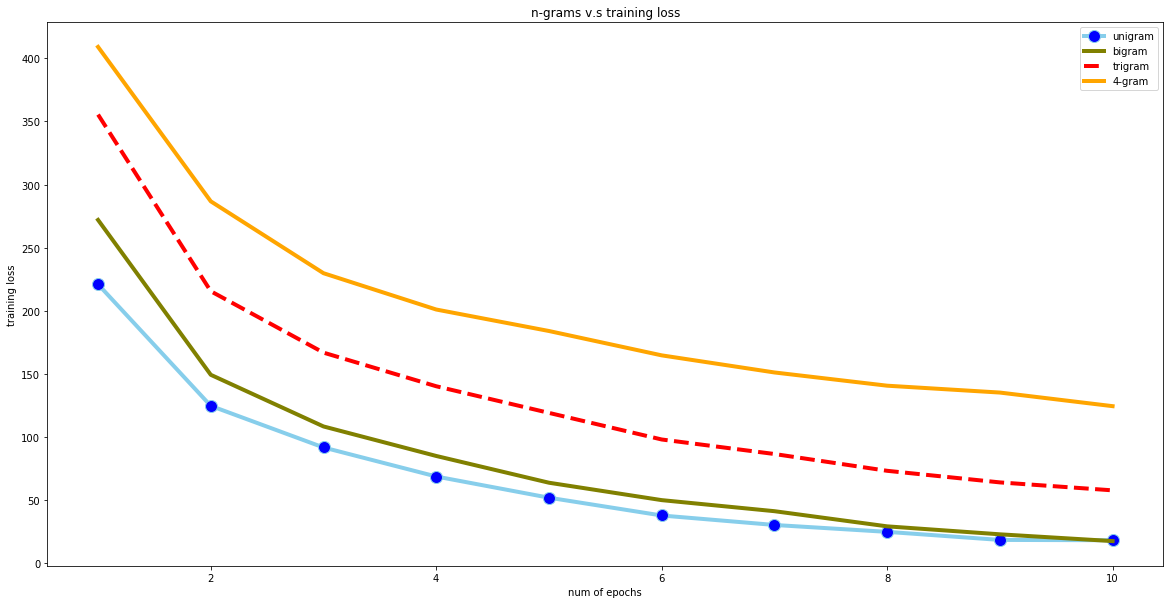

In [91]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot( range(1,11),ngram_loss_arr[0],marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'unigram')
plt.plot( range(1,11),ngram_loss_arr[1], marker='', color='olive', linewidth=4,label = 'bigram')
plt.plot( range(1,11),ngram_loss_arr[2], marker='', color='red', linewidth=4, linestyle='dashed', label="trigram")
plt.plot( range(1,11),ngram_loss_arr[3], marker='', color='orange', linewidth=4, label="4-gram")
plt.xlabel('num of epochs')
plt.ylabel('training loss')
plt.title('n-grams v.s training loss')
plt.legend()

plt.show()

### 3. Vocabulary size tuning

In [13]:
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data,1)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data,1)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,1)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))


Tokenizing val data
Tokenizing test data
Tokenizing train data


In [30]:
def find_best_vocasize(voca_ls):
    val_acc_arr = []
    val_acc_ls = []
    loss_arr = []
    for voca_size in voca_ls:
        max_vocab_size = voca_size
         ### build vocabulary 
        token2id, id2token = build_vocab(all_train_tokens, max_vocab_size=max_vocab_size )


        ### Convert token to the id in the dataset
        train_data_indices = token2index_dataset(train_data_tokens)
        val_data_indices = token2index_dataset(val_data_tokens)
        


        ### Dataloader (batch size & max_sentence_len)
        BATCH_SIZE = 32
        train_dataset = NewsGroupDataset(train_data_indices, train_targets)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=newsgroup_collate_func,
                                                   shuffle=True)

        val_dataset = NewsGroupDataset(val_data_indices, val_targets)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=newsgroup_collate_func,
                                                   shuffle=True)


        ### call the BOW models(emb_dim, padding_index)
        emb_dim = 100
        model = BagOfWords(len(id2token), emb_dim)


        ### Training the model (lr, optimizer, criterion)
        learning_rate = 0.01
        num_epochs = 10 # number epoch to train

        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print('When vocabulary size is {}'.format(max_vocab_size))
        epoch_loss = []
        epoch_val_acc = []
        for epoch in range(num_epochs):
            loss_ls = []
            for i, (data, lengths, labels) in enumerate(train_loader):
                model.train()
                data_batch, length_batch, label_batch = data, lengths, labels
                optimizer.zero_grad()
                outputs = model(data_batch, length_batch)
                loss = criterion(outputs, label_batch)
                loss_ls.append(loss)
                loss.backward()
                optimizer.step()
                # validate every 100 iterations
                if i > 0 and i % 100 == 0:
                    # validate
                    val_acc = test_model(val_loader, model)
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                               epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            epoch_loss.append(sum(loss_ls).item())
            epoch_val_acc.append(test_model(val_loader, model))
        
        ### Get the test acc
        print ("After training for {} epochs".format(num_epochs))
        print ("Val Acc {}".format(test_model(val_loader, model)))  
        val_acc_ls.append(test_model(val_loader, model))
        loss_arr.append(epoch_loss)
        val_acc_arr.append(epoch_val_acc)
        model.zero_grad()
        del(model)
    best_idx = val_acc_ls.index(max(val_acc_ls))
    best_n = voca_ls[best_idx]
    loss_arr = np.array(loss_arr)
    val_arr = np.array(val_acc_arr)
    print()
    print('For hyperparameter vocabulary size , {} performs best with val acc {}'.format(best_n, max(val_acc_ls)))
    return val_acc_ls, best_n,loss_arr, val_arr

In [31]:
vocasize_val_acc, vacasize_n, vocasize_loss_arr, vocasize_val_arr = find_best_vocasize([5000,10000,30000,50000,70000,100000])

When vocabulary size is 5000
Epoch: [1/10], Step: [101/625], Validation Acc: 82.0
Epoch: [1/10], Step: [201/625], Validation Acc: 85.94
Epoch: [1/10], Step: [301/625], Validation Acc: 87.24
Epoch: [1/10], Step: [401/625], Validation Acc: 87.78
Epoch: [1/10], Step: [501/625], Validation Acc: 87.78
Epoch: [1/10], Step: [601/625], Validation Acc: 88.12
Epoch: [2/10], Step: [101/625], Validation Acc: 87.84
Epoch: [2/10], Step: [201/625], Validation Acc: 87.18
Epoch: [2/10], Step: [301/625], Validation Acc: 87.3
Epoch: [2/10], Step: [401/625], Validation Acc: 88.32
Epoch: [2/10], Step: [501/625], Validation Acc: 87.94
Epoch: [2/10], Step: [601/625], Validation Acc: 88.06
Epoch: [3/10], Step: [101/625], Validation Acc: 86.18
Epoch: [3/10], Step: [201/625], Validation Acc: 87.36
Epoch: [3/10], Step: [301/625], Validation Acc: 87.16
Epoch: [3/10], Step: [401/625], Validation Acc: 87.74
Epoch: [3/10], Step: [501/625], Validation Acc: 87.58
Epoch: [3/10], Step: [601/625], Validation Acc: 86.2
Ep

Epoch: [5/10], Step: [601/625], Validation Acc: 87.26
Epoch: [6/10], Step: [101/625], Validation Acc: 87.16
Epoch: [6/10], Step: [201/625], Validation Acc: 86.86
Epoch: [6/10], Step: [301/625], Validation Acc: 85.8
Epoch: [6/10], Step: [401/625], Validation Acc: 87.04
Epoch: [6/10], Step: [501/625], Validation Acc: 86.84
Epoch: [6/10], Step: [601/625], Validation Acc: 87.28
Epoch: [7/10], Step: [101/625], Validation Acc: 86.78
Epoch: [7/10], Step: [201/625], Validation Acc: 86.74
Epoch: [7/10], Step: [301/625], Validation Acc: 86.36
Epoch: [7/10], Step: [401/625], Validation Acc: 86.46
Epoch: [7/10], Step: [501/625], Validation Acc: 86.42
Epoch: [7/10], Step: [601/625], Validation Acc: 86.3
Epoch: [8/10], Step: [101/625], Validation Acc: 86.68
Epoch: [8/10], Step: [201/625], Validation Acc: 85.76
Epoch: [8/10], Step: [301/625], Validation Acc: 86.2
Epoch: [8/10], Step: [401/625], Validation Acc: 86.24
Epoch: [8/10], Step: [501/625], Validation Acc: 86.08
Epoch: [8/10], Step: [601/625],

Epoch: [10/10], Step: [501/625], Validation Acc: 85.94
Epoch: [10/10], Step: [601/625], Validation Acc: 86.14
After training for 10 epochs
Val Acc 85.9
Test Acc 83.94
When vocabulary size is 100000
Epoch: [1/10], Step: [101/625], Validation Acc: 80.32
Epoch: [1/10], Step: [201/625], Validation Acc: 85.62
Epoch: [1/10], Step: [301/625], Validation Acc: 86.32
Epoch: [1/10], Step: [401/625], Validation Acc: 87.8
Epoch: [1/10], Step: [501/625], Validation Acc: 87.58
Epoch: [1/10], Step: [601/625], Validation Acc: 88.2
Epoch: [2/10], Step: [101/625], Validation Acc: 87.3
Epoch: [2/10], Step: [201/625], Validation Acc: 86.6
Epoch: [2/10], Step: [301/625], Validation Acc: 86.78
Epoch: [2/10], Step: [401/625], Validation Acc: 86.8
Epoch: [2/10], Step: [501/625], Validation Acc: 88.06
Epoch: [2/10], Step: [601/625], Validation Acc: 88.38
Epoch: [3/10], Step: [101/625], Validation Acc: 87.66
Epoch: [3/10], Step: [201/625], Validation Acc: 87.72
Epoch: [3/10], Step: [301/625], Validation Acc: 88.

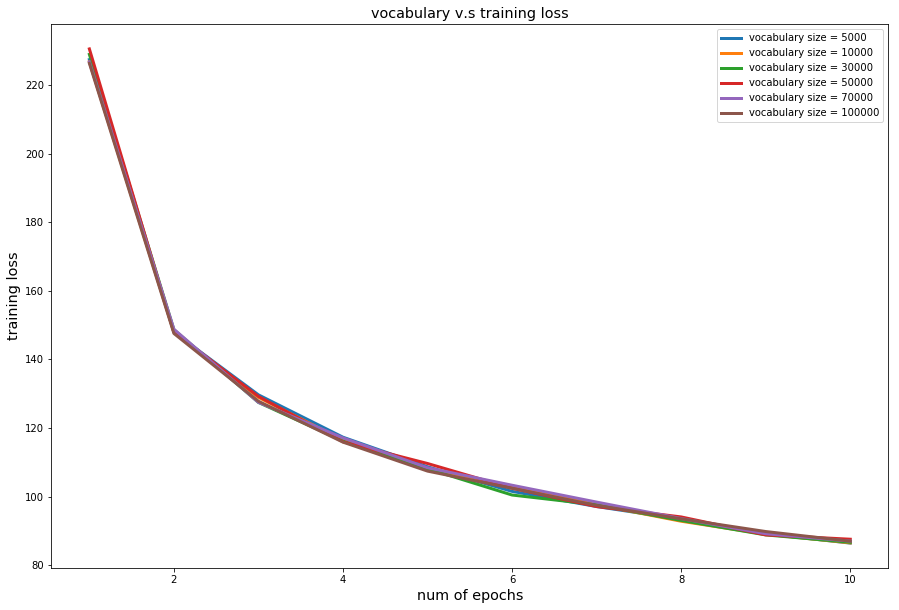

In [35]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
x = range(1,11)
voca_ls = [5000,10000,30000,50000,70000,100000]
for i in range(len(vocasize_loss_arr)):
    plt.plot(x,vocasize_loss_arr[i] ,linewidth = 3,label = 'vocabulary size = {}'.format(voca_ls[i]))
    
plt.xlabel('num of epochs',fontsize='x-large')
plt.ylabel('training loss',fontsize='x-large')
plt.title('vocabulary v.s training loss',fontsize='x-large')
plt.legend(loc='best')

plt.show()

### 4. Optimizer Tuning

In [38]:
### build vocabulary 
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size=30000)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
### Dataloader (batch size & max_sentence_len)
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)



In [209]:
def hyper_tuning_adam(emb_dim, lr, linear_annealing = False):
    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 10 # number epoch to train
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss() 
    epoch_loss = []
    epoch_val = []
    for epoch in range(num_epochs):
        if linear_annealing:
            lr = lr/(epoch+1)
        else: 
            lr = lr
        optimizer = torch.optim.Adam(model.parameters(), lr)
        loss_ls = []
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss_ls.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
        print('Epoch: [{}/{}], Traning loss: {}'.format(epoch+1, num_epochs,sum(loss_ls)))
        epoch_loss.append(sum(loss_ls).item())
        epoch_val.append(test_model(val_loader, model))
    val_acc = test_model(val_loader, model)   
    epoch_loss = np.array(epoch_loss)
    return epoch_loss, epoch_val, val_acc


In [73]:
from sklearn.model_selection import ParameterGrid
import pandas as pd
param_grid = {'emb_dim': [100,200,300],'lr':[1e-5,1e-4,1e-3,1e-2,1e-1,1] ,'linear_annealing': [True, False]}
#param_grid = {'emb_dim': [100],'lr':[0.01] ,'linear_annealing': [True, False]}
para_ls = list(ParameterGrid(param_grid))
df_record = pd.DataFrame(columns=['Emb-dim','Learning_Rate','Linearly-annealing','Training-loss for 10 epoch','Val-acc'])
import time
start = time.time()
for param in para_ls:
    #df_record = df_record.append({'Emb-dim': param['emb_dim'],'Learning_Rate': param['lr'],'Linearly-annealing': param['linear_annealing'] }, ignore_index=True)
    training_loss_arr, val_acc,epoch_val_acc = hyper_tuning_adam(param['emb_dim'],param['lr'], param['linear_annealing'])
    df_record = df_record.append({'Emb-dim': param['emb_dim'],'Learning_Rate': param['lr'],'Linearly-annealing': str(param['linear_annealing']),'Training-loss for 10 epoch': training_loss_arr,'Val-acc': val_acc,'Val-acc for 10 epoch': epoch_val_acc}, ignore_index=True)
end = time.time()
print('it takes: ', end-start)

Epoch: [1/10], Step: [101/625], Validation Acc: 52.2
Epoch: [1/10], Step: [201/625], Validation Acc: 52.36
Epoch: [1/10], Step: [301/625], Validation Acc: 52.62
Epoch: [1/10], Step: [401/625], Validation Acc: 52.9
Epoch: [1/10], Step: [501/625], Validation Acc: 53.36
Epoch: [1/10], Step: [601/625], Validation Acc: 53.54
Epoch: [1/10], Traning loss: 432.3640441894531
Epoch: [2/10], Step: [101/625], Validation Acc: 53.66
Epoch: [2/10], Step: [201/625], Validation Acc: 53.72
Epoch: [2/10], Step: [301/625], Validation Acc: 53.8
Epoch: [2/10], Step: [401/625], Validation Acc: 53.84
Epoch: [2/10], Step: [501/625], Validation Acc: 53.84
Epoch: [2/10], Step: [601/625], Validation Acc: 54.1
Epoch: [2/10], Traning loss: 431.69219970703125
Epoch: [3/10], Step: [101/625], Validation Acc: 54.08
Epoch: [3/10], Step: [201/625], Validation Acc: 54.1
Epoch: [3/10], Step: [301/625], Validation Acc: 54.14
Epoch: [3/10], Step: [401/625], Validation Acc: 54.22
Epoch: [3/10], Step: [501/625], Validation Acc

Epoch: [3/10], Step: [201/625], Validation Acc: 84.86
Epoch: [3/10], Step: [301/625], Validation Acc: 85.02
Epoch: [3/10], Step: [401/625], Validation Acc: 84.96
Epoch: [3/10], Step: [501/625], Validation Acc: 85.04
Epoch: [3/10], Step: [601/625], Validation Acc: 85.08
Epoch: [3/10], Traning loss: 207.85198974609375
Epoch: [4/10], Step: [101/625], Validation Acc: 85.08
Epoch: [4/10], Step: [201/625], Validation Acc: 85.1
Epoch: [4/10], Step: [301/625], Validation Acc: 85.06
Epoch: [4/10], Step: [401/625], Validation Acc: 85.04
Epoch: [4/10], Step: [501/625], Validation Acc: 85.14
Epoch: [4/10], Step: [601/625], Validation Acc: 85.14
Epoch: [4/10], Traning loss: 199.51205444335938
Epoch: [5/10], Step: [101/625], Validation Acc: 85.1
Epoch: [5/10], Step: [201/625], Validation Acc: 85.08
Epoch: [5/10], Step: [301/625], Validation Acc: 85.1
Epoch: [5/10], Step: [401/625], Validation Acc: 85.1
Epoch: [5/10], Step: [501/625], Validation Acc: 85.12
Epoch: [5/10], Step: [601/625], Validation A

Epoch: [5/10], Step: [401/625], Validation Acc: 88.34
Epoch: [5/10], Step: [501/625], Validation Acc: 88.26
Epoch: [5/10], Step: [601/625], Validation Acc: 88.16
Epoch: [5/10], Traning loss: 7.167850017547607
Epoch: [6/10], Step: [101/625], Validation Acc: 88.12
Epoch: [6/10], Step: [201/625], Validation Acc: 88.1
Epoch: [6/10], Step: [301/625], Validation Acc: 88.12
Epoch: [6/10], Step: [401/625], Validation Acc: 88.24
Epoch: [6/10], Step: [501/625], Validation Acc: 88.2
Epoch: [6/10], Step: [601/625], Validation Acc: 88.12
Epoch: [6/10], Traning loss: 6.289991855621338
Epoch: [7/10], Step: [101/625], Validation Acc: 88.16
Epoch: [7/10], Step: [201/625], Validation Acc: 88.16
Epoch: [7/10], Step: [301/625], Validation Acc: 88.14
Epoch: [7/10], Step: [401/625], Validation Acc: 88.18
Epoch: [7/10], Step: [501/625], Validation Acc: 88.18
Epoch: [7/10], Step: [601/625], Validation Acc: 88.14
Epoch: [7/10], Traning loss: 6.137511730194092
Epoch: [8/10], Step: [101/625], Validation Acc: 88.

Epoch: [7/10], Step: [501/625], Validation Acc: 58.16
Epoch: [7/10], Step: [601/625], Validation Acc: 58.22
Epoch: [7/10], Traning loss: 429.3757019042969
Epoch: [8/10], Step: [101/625], Validation Acc: 58.64
Epoch: [8/10], Step: [201/625], Validation Acc: 58.96
Epoch: [8/10], Step: [301/625], Validation Acc: 59.18
Epoch: [8/10], Step: [401/625], Validation Acc: 59.4
Epoch: [8/10], Step: [501/625], Validation Acc: 59.4
Epoch: [8/10], Step: [601/625], Validation Acc: 59.6
Epoch: [8/10], Traning loss: 428.51715087890625
Epoch: [9/10], Step: [101/625], Validation Acc: 59.88
Epoch: [9/10], Step: [201/625], Validation Acc: 60.12
Epoch: [9/10], Step: [301/625], Validation Acc: 60.22
Epoch: [9/10], Step: [401/625], Validation Acc: 60.4
Epoch: [9/10], Step: [501/625], Validation Acc: 60.56
Epoch: [9/10], Step: [601/625], Validation Acc: 60.72
Epoch: [9/10], Traning loss: 427.6542663574219
Epoch: [10/10], Step: [101/625], Validation Acc: 60.98
Epoch: [10/10], Step: [201/625], Validation Acc: 61

Epoch: [9/10], Step: [601/625], Validation Acc: 89.48
Epoch: [9/10], Traning loss: 57.92161178588867
Epoch: [10/10], Step: [101/625], Validation Acc: 89.56
Epoch: [10/10], Step: [201/625], Validation Acc: 89.5
Epoch: [10/10], Step: [301/625], Validation Acc: 89.52
Epoch: [10/10], Step: [401/625], Validation Acc: 89.44
Epoch: [10/10], Step: [501/625], Validation Acc: 89.28
Epoch: [10/10], Step: [601/625], Validation Acc: 89.42
Epoch: [10/10], Traning loss: 48.93961715698242
Epoch: [1/10], Step: [101/625], Validation Acc: 82.54
Epoch: [1/10], Step: [201/625], Validation Acc: 86.16
Epoch: [1/10], Step: [301/625], Validation Acc: 87.46
Epoch: [1/10], Step: [401/625], Validation Acc: 88.4
Epoch: [1/10], Step: [501/625], Validation Acc: 87.84
Epoch: [1/10], Step: [601/625], Validation Acc: 89.3
Epoch: [1/10], Traning loss: 215.0254669189453
Epoch: [2/10], Step: [101/625], Validation Acc: 88.88
Epoch: [2/10], Step: [201/625], Validation Acc: 88.42
Epoch: [2/10], Step: [301/625], Validation Ac

Epoch: [1/10], Traning loss: 5908.771484375
Epoch: [2/10], Step: [101/625], Validation Acc: 84.08
Epoch: [2/10], Step: [201/625], Validation Acc: 84.1
Epoch: [2/10], Step: [301/625], Validation Acc: 83.1
Epoch: [2/10], Step: [401/625], Validation Acc: 85.5
Epoch: [2/10], Step: [501/625], Validation Acc: 83.78
Epoch: [2/10], Step: [601/625], Validation Acc: 85.4
Epoch: [2/10], Traning loss: 8740.38671875
Epoch: [3/10], Step: [101/625], Validation Acc: 84.42
Epoch: [3/10], Step: [201/625], Validation Acc: 86.4
Epoch: [3/10], Step: [301/625], Validation Acc: 83.26
Epoch: [3/10], Step: [401/625], Validation Acc: 86.18
Epoch: [3/10], Step: [501/625], Validation Acc: 86.48
Epoch: [3/10], Step: [601/625], Validation Acc: 84.52
Epoch: [3/10], Traning loss: 10205.091796875
Epoch: [4/10], Step: [101/625], Validation Acc: 85.66
Epoch: [4/10], Step: [201/625], Validation Acc: 86.4
Epoch: [4/10], Step: [301/625], Validation Acc: 86.04
Epoch: [4/10], Step: [401/625], Validation Acc: 85.16
Epoch: [4/

Epoch: [4/10], Step: [201/625], Validation Acc: 69.54
Epoch: [4/10], Step: [301/625], Validation Acc: 69.52
Epoch: [4/10], Step: [401/625], Validation Acc: 69.5
Epoch: [4/10], Step: [501/625], Validation Acc: 69.52
Epoch: [4/10], Step: [601/625], Validation Acc: 69.52
Epoch: [4/10], Traning loss: 407.08746337890625
Epoch: [5/10], Step: [101/625], Validation Acc: 69.56
Epoch: [5/10], Step: [201/625], Validation Acc: 69.56
Epoch: [5/10], Step: [301/625], Validation Acc: 69.58
Epoch: [5/10], Step: [401/625], Validation Acc: 69.56
Epoch: [5/10], Step: [501/625], Validation Acc: 69.6
Epoch: [5/10], Step: [601/625], Validation Acc: 69.6
Epoch: [5/10], Traning loss: 406.6379699707031
Epoch: [6/10], Step: [101/625], Validation Acc: 69.6
Epoch: [6/10], Step: [201/625], Validation Acc: 69.6
Epoch: [6/10], Step: [301/625], Validation Acc: 69.6
Epoch: [6/10], Step: [401/625], Validation Acc: 69.58
Epoch: [6/10], Step: [501/625], Validation Acc: 69.6
Epoch: [6/10], Step: [601/625], Validation Acc: 

Epoch: [6/10], Step: [301/625], Validation Acc: 89.08
Epoch: [6/10], Step: [401/625], Validation Acc: 89.08
Epoch: [6/10], Step: [501/625], Validation Acc: 89.04
Epoch: [6/10], Step: [601/625], Validation Acc: 89.06
Epoch: [6/10], Traning loss: 22.694988250732422
Epoch: [7/10], Step: [101/625], Validation Acc: 89.04
Epoch: [7/10], Step: [201/625], Validation Acc: 89.06
Epoch: [7/10], Step: [301/625], Validation Acc: 89.06
Epoch: [7/10], Step: [401/625], Validation Acc: 89.04
Epoch: [7/10], Step: [501/625], Validation Acc: 89.04
Epoch: [7/10], Step: [601/625], Validation Acc: 89.04
Epoch: [7/10], Traning loss: 22.589426040649414
Epoch: [8/10], Step: [101/625], Validation Acc: 89.04
Epoch: [8/10], Step: [201/625], Validation Acc: 89.04
Epoch: [8/10], Step: [301/625], Validation Acc: 89.04
Epoch: [8/10], Step: [401/625], Validation Acc: 89.04
Epoch: [8/10], Step: [501/625], Validation Acc: 89.04
Epoch: [8/10], Step: [601/625], Validation Acc: 89.04
Epoch: [8/10], Traning loss: 22.57541656

Epoch: [8/10], Step: [401/625], Validation Acc: 87.18
Epoch: [8/10], Step: [501/625], Validation Acc: 87.18
Epoch: [8/10], Step: [601/625], Validation Acc: 87.18
Epoch: [8/10], Traning loss: 42.9716796875
Epoch: [9/10], Step: [101/625], Validation Acc: 87.18
Epoch: [9/10], Step: [201/625], Validation Acc: 87.18
Epoch: [9/10], Step: [301/625], Validation Acc: 87.18
Epoch: [9/10], Step: [401/625], Validation Acc: 87.18
Epoch: [9/10], Step: [501/625], Validation Acc: 87.18
Epoch: [9/10], Step: [601/625], Validation Acc: 87.18
Epoch: [9/10], Traning loss: 42.669883728027344
Epoch: [10/10], Step: [101/625], Validation Acc: 87.18
Epoch: [10/10], Step: [201/625], Validation Acc: 87.18
Epoch: [10/10], Step: [301/625], Validation Acc: 87.18
Epoch: [10/10], Step: [401/625], Validation Acc: 87.18
Epoch: [10/10], Step: [501/625], Validation Acc: 87.18
Epoch: [10/10], Step: [601/625], Validation Acc: 87.18
Epoch: [10/10], Traning loss: 42.63451385498047
Epoch: [1/10], Step: [101/625], Validation Ac

Epoch: [10/10], Step: [501/625], Validation Acc: 83.06
Epoch: [10/10], Step: [601/625], Validation Acc: 83.24
Epoch: [10/10], Traning loss: 252.684814453125
Epoch: [1/10], Step: [101/625], Validation Acc: 67.64
Epoch: [1/10], Step: [201/625], Validation Acc: 72.92
Epoch: [1/10], Step: [301/625], Validation Acc: 78.18
Epoch: [1/10], Step: [401/625], Validation Acc: 79.4
Epoch: [1/10], Step: [501/625], Validation Acc: 82.38
Epoch: [1/10], Step: [601/625], Validation Acc: 83.84
Epoch: [1/10], Traning loss: 340.9814758300781
Epoch: [2/10], Step: [101/625], Validation Acc: 84.64
Epoch: [2/10], Step: [201/625], Validation Acc: 85.26
Epoch: [2/10], Step: [301/625], Validation Acc: 85.74
Epoch: [2/10], Step: [401/625], Validation Acc: 86.34
Epoch: [2/10], Step: [501/625], Validation Acc: 86.6
Epoch: [2/10], Step: [601/625], Validation Acc: 87.04
Epoch: [2/10], Traning loss: 198.08169555664062
Epoch: [3/10], Step: [101/625], Validation Acc: 87.18
Epoch: [3/10], Step: [201/625], Validation Acc: 

Epoch: [2/10], Step: [601/625], Validation Acc: 87.5
Epoch: [2/10], Traning loss: 210.58323669433594
Epoch: [3/10], Step: [101/625], Validation Acc: 86.9
Epoch: [3/10], Step: [201/625], Validation Acc: 86.06
Epoch: [3/10], Step: [301/625], Validation Acc: 85.6
Epoch: [3/10], Step: [401/625], Validation Acc: 85.0
Epoch: [3/10], Step: [501/625], Validation Acc: 87.08
Epoch: [3/10], Step: [601/625], Validation Acc: 86.48
Epoch: [3/10], Traning loss: 222.9329833984375
Epoch: [4/10], Step: [101/625], Validation Acc: 85.92
Epoch: [4/10], Step: [201/625], Validation Acc: 84.52
Epoch: [4/10], Step: [301/625], Validation Acc: 85.54
Epoch: [4/10], Step: [401/625], Validation Acc: 84.72
Epoch: [4/10], Step: [501/625], Validation Acc: 86.4
Epoch: [4/10], Step: [601/625], Validation Acc: 85.98
Epoch: [4/10], Traning loss: 208.17987060546875
Epoch: [5/10], Step: [101/625], Validation Acc: 85.84
Epoch: [5/10], Step: [201/625], Validation Acc: 87.0
Epoch: [5/10], Step: [301/625], Validation Acc: 86.22

Epoch: [5/10], Step: [101/625], Validation Acc: 57.32
Epoch: [5/10], Step: [201/625], Validation Acc: 57.32
Epoch: [5/10], Step: [301/625], Validation Acc: 57.32
Epoch: [5/10], Step: [401/625], Validation Acc: 57.34
Epoch: [5/10], Step: [501/625], Validation Acc: 57.38
Epoch: [5/10], Step: [601/625], Validation Acc: 57.38
Epoch: [5/10], Traning loss: 428.2325744628906
Epoch: [6/10], Step: [101/625], Validation Acc: 57.38
Epoch: [6/10], Step: [201/625], Validation Acc: 57.38
Epoch: [6/10], Step: [301/625], Validation Acc: 57.38
Epoch: [6/10], Step: [401/625], Validation Acc: 57.4
Epoch: [6/10], Step: [501/625], Validation Acc: 57.4
Epoch: [6/10], Step: [601/625], Validation Acc: 57.4
Epoch: [6/10], Traning loss: 428.2240295410156
Epoch: [7/10], Step: [101/625], Validation Acc: 57.4
Epoch: [7/10], Step: [201/625], Validation Acc: 57.4
Epoch: [7/10], Step: [301/625], Validation Acc: 57.4
Epoch: [7/10], Step: [401/625], Validation Acc: 57.4
Epoch: [7/10], Step: [501/625], Validation Acc: 5

Epoch: [7/10], Step: [301/625], Validation Acc: 87.1
Epoch: [7/10], Step: [401/625], Validation Acc: 87.1
Epoch: [7/10], Step: [501/625], Validation Acc: 87.1
Epoch: [7/10], Step: [601/625], Validation Acc: 87.1
Epoch: [7/10], Traning loss: 158.43222045898438
Epoch: [8/10], Step: [101/625], Validation Acc: 87.12
Epoch: [8/10], Step: [201/625], Validation Acc: 87.12
Epoch: [8/10], Step: [301/625], Validation Acc: 87.12
Epoch: [8/10], Step: [401/625], Validation Acc: 87.12
Epoch: [8/10], Step: [501/625], Validation Acc: 87.12
Epoch: [8/10], Step: [601/625], Validation Acc: 87.12
Epoch: [8/10], Traning loss: 158.4249725341797
Epoch: [9/10], Step: [101/625], Validation Acc: 87.12
Epoch: [9/10], Step: [201/625], Validation Acc: 87.12
Epoch: [9/10], Step: [301/625], Validation Acc: 87.12
Epoch: [9/10], Step: [401/625], Validation Acc: 87.12
Epoch: [9/10], Step: [501/625], Validation Acc: 87.12
Epoch: [9/10], Step: [601/625], Validation Acc: 87.12
Epoch: [9/10], Traning loss: 158.424530029296

Epoch: [9/10], Step: [401/625], Validation Acc: 88.24
Epoch: [9/10], Step: [501/625], Validation Acc: 88.24
Epoch: [9/10], Step: [601/625], Validation Acc: 88.24
Epoch: [9/10], Traning loss: 7.472785949707031
Epoch: [10/10], Step: [101/625], Validation Acc: 88.24
Epoch: [10/10], Step: [201/625], Validation Acc: 88.24
Epoch: [10/10], Step: [301/625], Validation Acc: 88.24
Epoch: [10/10], Step: [401/625], Validation Acc: 88.24
Epoch: [10/10], Step: [501/625], Validation Acc: 88.24
Epoch: [10/10], Step: [601/625], Validation Acc: 88.24
Epoch: [10/10], Traning loss: 7.472239017486572
Epoch: [1/10], Step: [101/625], Validation Acc: 74.28
Epoch: [1/10], Step: [201/625], Validation Acc: 74.12
Epoch: [1/10], Step: [301/625], Validation Acc: 71.56
Epoch: [1/10], Step: [401/625], Validation Acc: 79.58
Epoch: [1/10], Step: [501/625], Validation Acc: 78.34
Epoch: [1/10], Step: [601/625], Validation Acc: 72.86
Epoch: [1/10], Traning loss: 14095.28515625
Epoch: [2/10], Step: [101/625], Validation Ac

Epoch: [1/10], Step: [501/625], Validation Acc: 65.3
Epoch: [1/10], Step: [601/625], Validation Acc: 64.92
Epoch: [1/10], Traning loss: 425.4321594238281
Epoch: [2/10], Step: [101/625], Validation Acc: 66.34
Epoch: [2/10], Step: [201/625], Validation Acc: 68.54
Epoch: [2/10], Step: [301/625], Validation Acc: 69.7
Epoch: [2/10], Step: [401/625], Validation Acc: 69.4
Epoch: [2/10], Step: [501/625], Validation Acc: 70.82
Epoch: [2/10], Step: [601/625], Validation Acc: 70.6
Epoch: [2/10], Traning loss: 404.0475158691406
Epoch: [3/10], Step: [101/625], Validation Acc: 71.12
Epoch: [3/10], Step: [201/625], Validation Acc: 72.06
Epoch: [3/10], Step: [301/625], Validation Acc: 72.78
Epoch: [3/10], Step: [401/625], Validation Acc: 72.92
Epoch: [3/10], Step: [501/625], Validation Acc: 73.46
Epoch: [3/10], Step: [601/625], Validation Acc: 74.02
Epoch: [3/10], Traning loss: 380.4822082519531
Epoch: [4/10], Step: [101/625], Validation Acc: 74.7
Epoch: [4/10], Step: [201/625], Validation Acc: 75.1
E

Epoch: [3/10], Step: [601/625], Validation Acc: 87.36
Epoch: [3/10], Traning loss: 56.19211959838867
Epoch: [4/10], Step: [101/625], Validation Acc: 87.74
Epoch: [4/10], Step: [201/625], Validation Acc: 87.96
Epoch: [4/10], Step: [301/625], Validation Acc: 87.48
Epoch: [4/10], Step: [401/625], Validation Acc: 87.64
Epoch: [4/10], Step: [501/625], Validation Acc: 87.48
Epoch: [4/10], Step: [601/625], Validation Acc: 87.16
Epoch: [4/10], Traning loss: 33.26644515991211
Epoch: [5/10], Step: [101/625], Validation Acc: 87.62
Epoch: [5/10], Step: [201/625], Validation Acc: 87.06
Epoch: [5/10], Step: [301/625], Validation Acc: 86.98
Epoch: [5/10], Step: [401/625], Validation Acc: 86.74
Epoch: [5/10], Step: [501/625], Validation Acc: 85.94
Epoch: [5/10], Step: [601/625], Validation Acc: 86.72
Epoch: [5/10], Traning loss: 21.566537857055664
Epoch: [6/10], Step: [101/625], Validation Acc: 86.7
Epoch: [6/10], Step: [201/625], Validation Acc: 87.0
Epoch: [6/10], Step: [301/625], Validation Acc: 87

Epoch: [6/10], Step: [101/625], Validation Acc: 86.52
Epoch: [6/10], Step: [201/625], Validation Acc: 86.82
Epoch: [6/10], Step: [301/625], Validation Acc: 86.84
Epoch: [6/10], Step: [401/625], Validation Acc: 84.06
Epoch: [6/10], Step: [501/625], Validation Acc: 85.22
Epoch: [6/10], Step: [601/625], Validation Acc: 86.02
Epoch: [6/10], Traning loss: 35316.37890625
Epoch: [7/10], Step: [101/625], Validation Acc: 87.0
Epoch: [7/10], Step: [201/625], Validation Acc: 85.44
Epoch: [7/10], Step: [301/625], Validation Acc: 86.16
Epoch: [7/10], Step: [401/625], Validation Acc: 86.5
Epoch: [7/10], Step: [501/625], Validation Acc: 85.52
Epoch: [7/10], Step: [601/625], Validation Acc: 86.26
Epoch: [7/10], Traning loss: 33156.78515625
Epoch: [8/10], Step: [101/625], Validation Acc: 86.68
Epoch: [8/10], Step: [201/625], Validation Acc: 85.94
Epoch: [8/10], Step: [301/625], Validation Acc: 86.22
Epoch: [8/10], Step: [401/625], Validation Acc: 86.86
Epoch: [8/10], Step: [501/625], Validation Acc: 86

In [189]:
df_record

,Emb-dim,Learning_Rate,Linearly-annealing,Training-loss for 10 epoch,Val-acc,Val-acc for 10 epoch
0,100,0.00001,True,"[432.3640441894531, 431.69219970703125, 431.39...",54.32,"[53.54, 54.1, 54.24, 54.34, 54.3, 54.32, 54.32..."
1,100,0.00010,True,"[430.3427429199219, 423.5675964355469, 420.347...",64.88,"[59.98, 63.82, 64.68, 64.8, 64.9, 64.88, 64.88..."
2,100,0.00100,True,"[365.09722900390625, 241.30010986328125, 207.8...",85.20,"[82.28, 84.64, 85.08, 85.14, 85.16, 85.2, 85.2..."
3,100,0.01000,True,"[217.99888610839844, 83.922607421875, 44.27945...",89.26,"[88.8, 89.28, 89.2, 89.2, 89.22, 89.26, 89.26,..."
4,100,0.10000,True,"[230.8411102294922, 90.27665710449219, 31.2600...",88.14,"[87.62, 88.1, 88.58, 88.28, 88.16, 88.12, 88.1..."
5,100,1.00000,True,"[4028.039794921875, 3692.161376953125, 994.106...",86.92,"[81.34, 85.7, 86.54, 87.12, 87.48, 86.9, 86.92..."
6,100,0.00001,False,"[435.253173828125, 434.04547119140625, 432.997...",61.82,"[48.38, 49.6, 51.08, 52.56, 54.74, 56.76, 58.2..."
7,100,0.00010,False,"[429.84503173828125, 421.247314453125, 410.653...",81.06,"[60.52, 66.56, 70.82, 72.58, 74.5, 76.12, 77.9..."
8,100,0.00100,False,"[366.21636962890625, 221.83570861816406, 165.5...",89.26,"[81.84, 85.94, 87.82, 88.98, 89.32, 89.42, 89...."
9,100,0.01000,False,"[215.0254669189453, 97.75621795654297, 55.4634...",86.52,"[89.3, 88.54, 87.92, 87.22, 87.06, 87.3, 86.78..."


In [190]:
df_record.to_csv('embed_records.csv')

In [82]:
def hyper_tuning_sgd(emb_dim, lr,linear_annealing = False):
    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 10 # number epoch to train
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss() 
    epoch_loss = []
    for epoch in range(num_epochs):
        if linear_annealing:
            lr = lr/(epoch+1)
        else: 
            lr = lr
        optimizer = torch.optim.SGD(model.parameters(), lr,momentum = 0.9)
        loss_ls = []
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss_ls.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
        print('Epoch: [{}/{}], Traning loss: {}'.format(epoch+1, num_epochs,sum(loss_ls)))
        epoch_loss.append(sum(loss_ls).item())
        val_acc = test_model(val_loader, model)
    epoch_loss = np.array(epoch_loss)
    return epoch_loss, val_acc

In [83]:
from sklearn.model_selection import ParameterGrid
import pandas as pd
param_grid_sgd = {'emb_dim': [100,200,300],'lr':[1e-4,1e-3,1e-2,1e-1,1] ,'linear_annealing': [True, False]}
#param_grid_sgd = {'emb_dim': [100],'lr':[0.01] ,'linear_annealing': [True, False]}
para_ls_sgd = list(ParameterGrid(param_grid_sgd))
df_record_sgd = pd.DataFrame(columns=['Emb-dim','Learning_Rate','Linearly-annealing','Training-loss for 10 epoch','Val-acc'])
import time
start = time.time()
for param in para_ls_sgd:
    #df_record = df_record.append({'Emb-dim': param['emb_dim'],'Learning_Rate': param['lr'],'Linearly-annealing': param['linear_annealing'] }, ignore_index=True)
    training_loss_arr, val_acc = hyper_tuning_sgd(param['emb_dim'],param['lr'], param['linear_annealing'])
    df_record_sgd = df_record_sgd.append({'Emb-dim': param['emb_dim'],'Learning_Rate': param['lr'],'Linearly-annealing': str(param['linear_annealing']),'Training-loss for 10 epoch': training_loss_arr,'Val-acc': val_acc}, ignore_index=True)
end = time.time()
print('it takes: ', end-start)

Epoch: [1/10], Step: [201/625], Validation Acc: 50.2
Epoch: [1/10], Step: [401/625], Validation Acc: 50.26
Epoch: [1/10], Step: [601/625], Validation Acc: 51.02
Epoch: [1/10], Traning loss: 433.8737487792969
Epoch: [2/10], Step: [201/625], Validation Acc: 51.0
Epoch: [2/10], Step: [401/625], Validation Acc: 50.86
Epoch: [2/10], Step: [601/625], Validation Acc: 50.88
Epoch: [2/10], Traning loss: 432.95758056640625
Epoch: [3/10], Step: [201/625], Validation Acc: 50.9
Epoch: [3/10], Step: [401/625], Validation Acc: 50.96
Epoch: [3/10], Step: [601/625], Validation Acc: 50.88
Epoch: [3/10], Traning loss: 432.6719665527344
Epoch: [4/10], Step: [201/625], Validation Acc: 51.02
Epoch: [4/10], Step: [401/625], Validation Acc: 51.04
Epoch: [4/10], Step: [601/625], Validation Acc: 50.96
Epoch: [4/10], Traning loss: 432.5931091308594
Epoch: [5/10], Step: [201/625], Validation Acc: 50.98
Epoch: [5/10], Step: [401/625], Validation Acc: 50.98
Epoch: [5/10], Step: [601/625], Validation Acc: 50.98
Epoc

Epoch: [10/10], Step: [601/625], Validation Acc: 75.2
Epoch: [10/10], Traning loss: 313.36260986328125
Epoch: [1/10], Step: [201/625], Validation Acc: 70.58
Epoch: [1/10], Step: [401/625], Validation Acc: 79.84
Epoch: [1/10], Step: [601/625], Validation Acc: 77.82
Epoch: [1/10], Traning loss: 350.3826599121094
Epoch: [2/10], Step: [201/625], Validation Acc: 82.24
Epoch: [2/10], Step: [401/625], Validation Acc: 80.94
Epoch: [2/10], Step: [601/625], Validation Acc: 82.48
Epoch: [2/10], Traning loss: 239.52024841308594
Epoch: [3/10], Step: [201/625], Validation Acc: 84.24
Epoch: [3/10], Step: [401/625], Validation Acc: 83.7
Epoch: [3/10], Step: [601/625], Validation Acc: 84.52
Epoch: [3/10], Traning loss: 204.2912139892578
Epoch: [4/10], Step: [201/625], Validation Acc: 84.72
Epoch: [4/10], Step: [401/625], Validation Acc: 84.94
Epoch: [4/10], Step: [601/625], Validation Acc: 85.12
Epoch: [4/10], Traning loss: 193.2042694091797
Epoch: [5/10], Step: [201/625], Validation Acc: 85.14
Epoch: 

Epoch: [9/10], Traning loss: 347.0751037597656
Epoch: [10/10], Step: [201/625], Validation Acc: 71.36
Epoch: [10/10], Step: [401/625], Validation Acc: 70.96
Epoch: [10/10], Step: [601/625], Validation Acc: 71.34
Epoch: [10/10], Traning loss: 342.4521484375
Epoch: [1/10], Step: [201/625], Validation Acc: 68.08
Epoch: [1/10], Step: [401/625], Validation Acc: 68.78
Epoch: [1/10], Step: [601/625], Validation Acc: 72.82
Epoch: [1/10], Traning loss: 371.37371826171875
Epoch: [2/10], Step: [201/625], Validation Acc: 72.04
Epoch: [2/10], Step: [401/625], Validation Acc: 74.84
Epoch: [2/10], Step: [601/625], Validation Acc: 75.88
Epoch: [2/10], Traning loss: 324.422607421875
Epoch: [3/10], Step: [201/625], Validation Acc: 77.02
Epoch: [3/10], Step: [401/625], Validation Acc: 77.1
Epoch: [3/10], Step: [601/625], Validation Acc: 77.48
Epoch: [3/10], Traning loss: 297.45098876953125
Epoch: [4/10], Step: [201/625], Validation Acc: 78.7
Epoch: [4/10], Step: [401/625], Validation Acc: 78.28
Epoch: [4

Epoch: [9/10], Step: [201/625], Validation Acc: 63.96
Epoch: [9/10], Step: [401/625], Validation Acc: 63.96
Epoch: [9/10], Step: [601/625], Validation Acc: 63.96
Epoch: [9/10], Traning loss: 416.8837585449219
Epoch: [10/10], Step: [201/625], Validation Acc: 63.96
Epoch: [10/10], Step: [401/625], Validation Acc: 63.96
Epoch: [10/10], Step: [601/625], Validation Acc: 63.96
Epoch: [10/10], Traning loss: 416.883544921875
Epoch: [1/10], Step: [201/625], Validation Acc: 65.16
Epoch: [1/10], Step: [401/625], Validation Acc: 66.88
Epoch: [1/10], Step: [601/625], Validation Acc: 67.08
Epoch: [1/10], Traning loss: 408.6046142578125
Epoch: [2/10], Step: [201/625], Validation Acc: 68.26
Epoch: [2/10], Step: [401/625], Validation Acc: 68.58
Epoch: [2/10], Step: [601/625], Validation Acc: 68.76
Epoch: [2/10], Traning loss: 385.27685546875
Epoch: [3/10], Step: [201/625], Validation Acc: 69.0
Epoch: [3/10], Step: [401/625], Validation Acc: 68.96
Epoch: [3/10], Step: [601/625], Validation Acc: 69.24
Ep

Epoch: [8/10], Step: [401/625], Validation Acc: 58.96
Epoch: [8/10], Step: [601/625], Validation Acc: 58.94
Epoch: [8/10], Traning loss: 426.4186706542969
Epoch: [9/10], Step: [201/625], Validation Acc: 59.24
Epoch: [9/10], Step: [401/625], Validation Acc: 59.58
Epoch: [9/10], Step: [601/625], Validation Acc: 59.68
Epoch: [9/10], Traning loss: 425.530029296875
Epoch: [10/10], Step: [201/625], Validation Acc: 59.9
Epoch: [10/10], Step: [401/625], Validation Acc: 60.18
Epoch: [10/10], Step: [601/625], Validation Acc: 60.36
Epoch: [10/10], Traning loss: 424.666748046875
Epoch: [1/10], Step: [201/625], Validation Acc: 54.26
Epoch: [1/10], Step: [401/625], Validation Acc: 57.52
Epoch: [1/10], Step: [601/625], Validation Acc: 60.02
Epoch: [1/10], Traning loss: 430.1092834472656
Epoch: [2/10], Step: [201/625], Validation Acc: 61.7
Epoch: [2/10], Step: [401/625], Validation Acc: 63.2
Epoch: [2/10], Step: [601/625], Validation Acc: 64.04
Epoch: [2/10], Traning loss: 422.5433044433594
Epoch: [3/

Epoch: [7/10], Step: [601/625], Validation Acc: 85.64
Epoch: [7/10], Traning loss: 171.25869750976562
Epoch: [8/10], Step: [201/625], Validation Acc: 84.62
Epoch: [8/10], Step: [401/625], Validation Acc: 87.08
Epoch: [8/10], Step: [601/625], Validation Acc: 86.2
Epoch: [8/10], Traning loss: 162.61619567871094
Epoch: [9/10], Step: [201/625], Validation Acc: 81.46
Epoch: [9/10], Step: [401/625], Validation Acc: 83.9
Epoch: [9/10], Step: [601/625], Validation Acc: 83.34
Epoch: [9/10], Traning loss: 163.25328063964844
Epoch: [10/10], Step: [201/625], Validation Acc: 84.2
Epoch: [10/10], Step: [401/625], Validation Acc: 86.3
Epoch: [10/10], Step: [601/625], Validation Acc: 80.68
Epoch: [10/10], Traning loss: 150.0955810546875
Epoch: [1/10], Step: [201/625], Validation Acc: 51.04
Epoch: [1/10], Step: [401/625], Validation Acc: 52.44
Epoch: [1/10], Step: [601/625], Validation Acc: 53.06
Epoch: [1/10], Traning loss: 432.2843933105469
Epoch: [2/10], Step: [201/625], Validation Acc: 54.68
Epoch:

Epoch: [6/10], Traning loss: 278.3917236328125
Epoch: [7/10], Step: [201/625], Validation Acc: 78.1
Epoch: [7/10], Step: [401/625], Validation Acc: 78.1
Epoch: [7/10], Step: [601/625], Validation Acc: 78.06
Epoch: [7/10], Traning loss: 278.33697509765625
Epoch: [8/10], Step: [201/625], Validation Acc: 78.1
Epoch: [8/10], Step: [401/625], Validation Acc: 78.1
Epoch: [8/10], Step: [601/625], Validation Acc: 78.1
Epoch: [8/10], Traning loss: 278.3302001953125
Epoch: [9/10], Step: [201/625], Validation Acc: 78.1
Epoch: [9/10], Step: [401/625], Validation Acc: 78.1
Epoch: [9/10], Step: [601/625], Validation Acc: 78.1
Epoch: [9/10], Traning loss: 278.3296813964844
Epoch: [10/10], Step: [201/625], Validation Acc: 78.1
Epoch: [10/10], Step: [401/625], Validation Acc: 78.1
Epoch: [10/10], Step: [601/625], Validation Acc: 78.1
Epoch: [10/10], Traning loss: 278.3296203613281
Epoch: [1/10], Step: [201/625], Validation Acc: 75.82
Epoch: [1/10], Step: [401/625], Validation Acc: 80.08
Epoch: [1/10], 

Epoch: [6/10], Step: [401/625], Validation Acc: 75.5
Epoch: [6/10], Step: [601/625], Validation Acc: 75.42
Epoch: [6/10], Traning loss: 319.8182678222656
Epoch: [7/10], Step: [201/625], Validation Acc: 75.54
Epoch: [7/10], Step: [401/625], Validation Acc: 75.94
Epoch: [7/10], Step: [601/625], Validation Acc: 76.14
Epoch: [7/10], Traning loss: 313.96429443359375
Epoch: [8/10], Step: [201/625], Validation Acc: 76.4
Epoch: [8/10], Step: [401/625], Validation Acc: 76.44
Epoch: [8/10], Step: [601/625], Validation Acc: 76.48
Epoch: [8/10], Traning loss: 308.389404296875
Epoch: [9/10], Step: [201/625], Validation Acc: 76.7
Epoch: [9/10], Step: [401/625], Validation Acc: 76.6
Epoch: [9/10], Step: [601/625], Validation Acc: 76.82
Epoch: [9/10], Traning loss: 304.0434265136719
Epoch: [10/10], Step: [201/625], Validation Acc: 77.14
Epoch: [10/10], Step: [401/625], Validation Acc: 77.16
Epoch: [10/10], Step: [601/625], Validation Acc: 77.0
Epoch: [10/10], Traning loss: 299.6481628417969
Epoch: [1/

In [84]:
df_record_sgd.to_csv('sgd_records.csv')

,Emb-dim,Learning_Rate,Linearly-annealing,Training-loss for 10 epoch,Val-acc
0,100,0.0001,True,"[433.8737487792969, 432.95758056640625, 432.67...",51.00
1,100,0.0010,True,"[430.4723205566406, 425.25408935546875, 423.30...",61.66
2,100,0.0100,True,"[416.0072021484375, 397.89678955078125, 392.99...",66.18
3,100,0.1000,True,"[379.41015625, 334.7493896484375, 319.26739501...",75.20
4,100,1.0000,True,"[350.3826599121094, 239.52024841308594, 204.29...",85.08
5,100,0.0001,False,"[436.7900695800781, 434.7586975097656, 433.774...",56.62
6,100,0.0010,False,"[431.4173889160156, 426.50360107421875, 422.54...",65.52
7,100,0.0100,False,"[415.7868347167969, 393.276123046875, 381.2159...",71.56
8,100,0.1000,False,"[371.37371826171875, 324.422607421875, 297.450...",83.32
9,100,1.0000,False,"[344.6839294433594, 263.450927734375, 232.4197...",86.70


In [86]:
df_record_sgd.to_csv('sgd_records.csv')

## 4.2 Viz of results

In [109]:
adam_emb = df_record.loc[(df_record['Learning_Rate']==0.00100) &(df_record['Linearly-annealing']=='True')]
adam_emb

,Emb-dim,Learning_Rate,Linearly-annealing,Training-loss for 10 epoch,Val-acc
2,100,0.001,True,"[365.09722900390625, 241.30010986328125, 207.8...",85.20
14,200,0.001,True,"[338.2981872558594, 210.4760284423828, 181.095...",86.38
26,300,0.001,True,"[328.08258056640625, 197.3768310546875, 168.32...",87.12


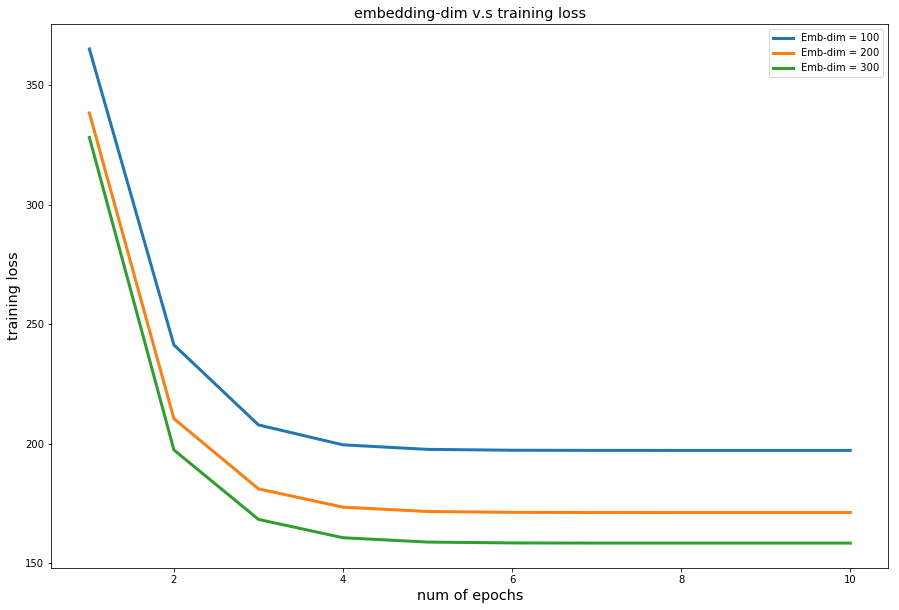

In [111]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
x = range(1,11)
#voca_ls = [5000,10000,30000,50000,70000,100000]
for i in range(len(adam_emb)):
    plt.plot(x, 'Training-loss for 10 epoch', data=adam_emb.iloc[i],linewidth = 3, label = 'Emb-dim = {}'.format(adam_emb.iloc[i]['Emb-dim']))
# plt.plot( range(1,11),vocasize_loss_arr[0],marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'unigram')
# plt.plot( range(1,11),vocasize_loss_arr[1], marker='', color='olive', linewidth=4,label = 'bigram')
# plt.plot( range(1,11),ngram_loss_arr[2], marker='', color='red', linewidth=4, linestyle='dashed', label="trigram")
# plt.plot( range(1,11),ngram_loss_arr[3], marker='', color='orange', linewidth=4, label="4-gram")
plt.xlabel('num of epochs',fontsize='x-large')
plt.ylabel('training loss',fontsize='x-large')
plt.title('embedding-dim v.s training loss',fontsize='x-large')
plt.legend(loc='best')

plt.show()

In [112]:
adam_lr = df_record.loc[(df_record['Emb-dim']==300) &(df_record['Linearly-annealing']=='True')]
adam_lr

,Emb-dim,Learning_Rate,Linearly-annealing,Training-loss for 10 epoch,Val-acc
24,300,0.00001,True,"[430.5599060058594, 429.11395263671875, 428.47...",57.40
25,300,0.00010,True,"[423.96563720703125, 409.08843994140625, 401.8...",71.08
26,300,0.00100,True,"[328.08258056640625, 197.3768310546875, 168.32...",87.12
27,300,0.01000,True,"[213.3622283935547, 80.4162826538086, 37.05733...",89.38
28,300,0.10000,True,"[317.4501953125, 145.32376098632812, 51.006225...",88.24
29,300,1.00000,True,"[14095.28515625, 11496.630859375, 3559.9877929...",87.14


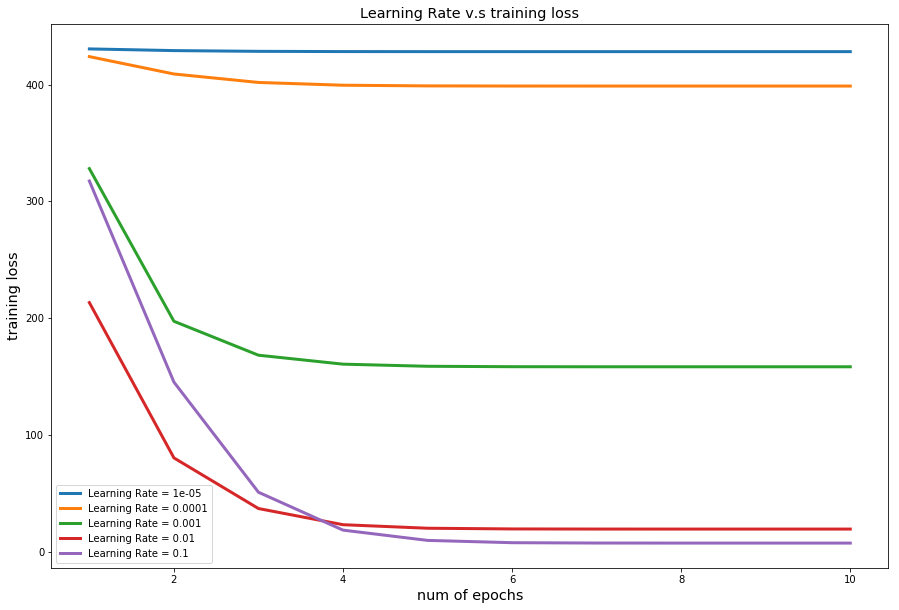

In [117]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
x = range(1,11)
#voca_ls = [5000,10000,30000,50000,70000,100000]
for i in range(len(adam_lr)-1):
    plt.plot(x, 'Training-loss for 10 epoch', data=adam_lr.iloc[i],linewidth = 3, label = 'Learning Rate = {}'.format(adam_lr.iloc[i]['Learning_Rate']))
# plt.plot( range(1,11),vocasize_loss_arr[0],marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'unigram')
# plt.plot( range(1,11),vocasize_loss_arr[1], marker='', color='olive', linewidth=4,label = 'bigram')
# plt.plot( range(1,11),ngram_loss_arr[2], marker='', color='red', linewidth=4, linestyle='dashed', label="trigram")
# plt.plot( range(1,11),ngram_loss_arr[3], marker='', color='orange', linewidth=4, label="4-gram")
plt.xlabel('num of epochs',fontsize='x-large')
plt.ylabel('training loss',fontsize='x-large')
plt.title('Learning Rate v.s training loss',fontsize='x-large')
plt.legend(loc='best')

plt.show()

In [122]:
adam_annealing1 = df_record.loc[(df_record['Learning_Rate']==0.01) ]
adam_annealing1

,Emb-dim,Learning_Rate,Linearly-annealing,Training-loss for 10 epoch,Val-acc
3,100,0.01,True,"[217.99888610839844, 83.922607421875, 44.27945...",89.26
9,100,0.01,False,"[215.0254669189453, 97.75621795654297, 55.4634...",86.52
15,200,0.01,True,"[212.77813720703125, 81.98033905029297, 39.338...",89.04
21,200,0.01,False,"[210.49069213867188, 97.7767333984375, 54.4772...",86.48
27,300,0.01,True,"[213.3622283935547, 80.4162826538086, 37.05733...",89.38
33,300,0.01,False,"[210.72091674804688, 96.76936340332031, 56.192...",86.40


In [128]:
adam_annealing = adam_annealing1.loc[(df_record['Emb-dim']==300) ]

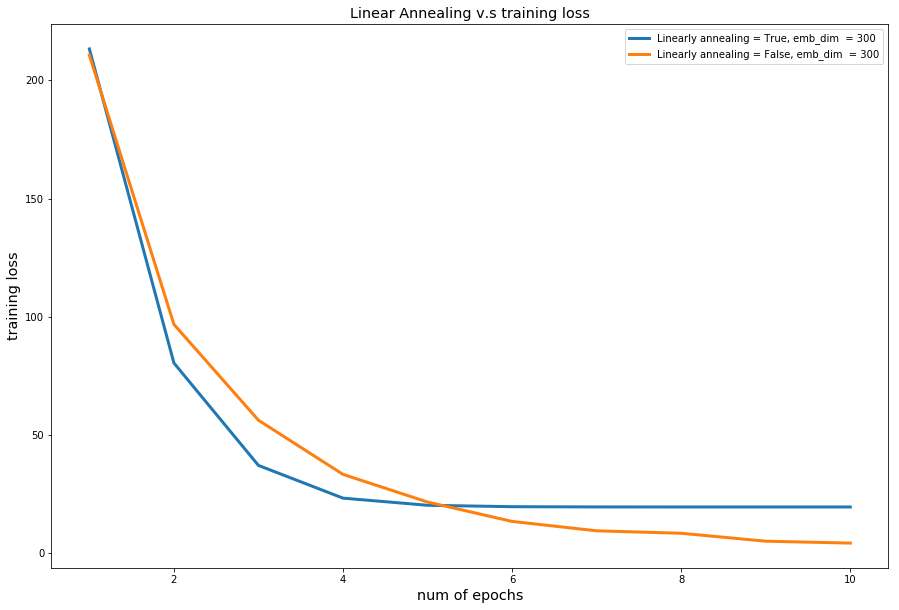

In [129]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
x = range(1,11)
#voca_ls = [5000,10000,30000,50000,70000,100000]
for i in range(len(adam_annealing)):
    plt.plot(x, 'Training-loss for 10 epoch', data=adam_annealing.iloc[i],linewidth = 3, label = 'Linearly annealing = {}, emb_dim  = {}'.format(adam_annealing.iloc[i]['Linearly-annealing'],adam_annealing.iloc[i]['Emb-dim']))
# plt.plot( range(1,11),vocasize_loss_arr[0],marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'unigram')
# plt.plot( range(1,11),vocasize_loss_arr[1], marker='', color='olive', linewidth=4,label = 'bigram')
# plt.plot( range(1,11),ngram_loss_arr[2], marker='', color='red', linewidth=4, linestyle='dashed', label="trigram")
# plt.plot( range(1,11),ngram_loss_arr[3], marker='', color='orange', linewidth=4, label="4-gram")
plt.xlabel('num of epochs',fontsize='x-large')
plt.ylabel('training loss',fontsize='x-large')
plt.title('Linear Annealing v.s training loss',fontsize='x-large')
plt.legend(loc='best')

plt.show()

### The best model

In [362]:
# Load the data with uni-gram and lower case and remove punctuactions
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))


In [363]:
### build vocabulary with size 30000
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size=30000)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
### Dataloader (batch size & max_sentence_len)
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [211]:
emb_dim = 300
model = BagOfWords(len(id2token), emb_dim)
lr= 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss() 
best_epoch_val = []
best_epoch_loss = []
for epoch in range(num_epochs):
    lr = lr/(epoch+1)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_ls = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_ls.append(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    best_epoch_loss.append(sum(loss_ls).item())
    best_epoch_val.append(test_model(val_loader, model))
    
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

Epoch: [1/10], Step: [101/625], Validation Acc: 83.7
Epoch: [1/10], Step: [201/625], Validation Acc: 86.52
Epoch: [1/10], Step: [301/625], Validation Acc: 87.36
Epoch: [1/10], Step: [401/625], Validation Acc: 88.24
Epoch: [1/10], Step: [501/625], Validation Acc: 88.0
Epoch: [1/10], Step: [601/625], Validation Acc: 88.62
Epoch: [2/10], Step: [101/625], Validation Acc: 89.26
Epoch: [2/10], Step: [201/625], Validation Acc: 89.18
Epoch: [2/10], Step: [301/625], Validation Acc: 88.84
Epoch: [2/10], Step: [401/625], Validation Acc: 88.76
Epoch: [2/10], Step: [501/625], Validation Acc: 88.98
Epoch: [2/10], Step: [601/625], Validation Acc: 88.66
Epoch: [3/10], Step: [101/625], Validation Acc: 88.7
Epoch: [3/10], Step: [201/625], Validation Acc: 88.86
Epoch: [3/10], Step: [301/625], Validation Acc: 88.94
Epoch: [3/10], Step: [401/625], Validation Acc: 89.12
Epoch: [3/10], Step: [501/625], Validation Acc: 89.04
Epoch: [3/10], Step: [601/625], Validation Acc: 88.68
Epoch: [4/10], Step: [101/625],

In [374]:
val_loader_best = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=500,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [419]:
model.eval()
for data, lengths, labels in val_loader_best:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)#compute the probalities
    predicted = outputs.max(1, keepdim=True)[1]
    wrong_idx = (predicted.eq(labels.view_as(predicted))==0).nonzero().numpy()
   # print(label_batch[10].item(), predicted[10].item())
    break

In [433]:
wrong_idx_ls = []
for i in range(len(wrong_idx)):
    wrong_idx_ls.append(wrong_idx[i][0])

In [434]:
for data, lengths, labels in val_loader_best:
    data_batch, length_batch, label_batch = data, lengths, labels
    #print(data_batch[409])
    print(label_batch[409])
    test_7 = data_batch[409]
    
    
    break

tensor(1)


In [410]:
corval_sent3 = ' '.join([id2token[i] for i in list(test_7.numpy()) if (i!=0)])
#label 1, predict 1
corval_sent3

'all this talk about this being a bad movie is nonsense as a matter of fact this is the best movie ive ever seen its an excellent story and the actors in the movie are some of the best i would not give criticism to any of the actors that movie is the best and it will always stay that way'

In [401]:
corval_sent2 = ' '.join([id2token[i] for i in list(test_6.numpy()) if (i!=0)])
#label 1, predict 1
corval_sent2

'if you are a fan of zorro indiana jones or action in general this is a mustsee directed by <unk> ace team of william <unk> and john english and starring reed hadley as don <unk> this serial delivers i wont bore you with the plot who cares less talking more fighting what really matters here is hadleys superb interpretation of the characters and the stunt work of dale van <unk> and <unk> <unk> stunt spoilers follow you can see the influence this film had on lucas and spielberg zorro gets caught in the original version of the star wars trash <unk> in one chapter trapped on a rope bridge ala temple of doom in another does a raiders <unk> transfer and even flees through a tunnel while the baddies knock over a huge water tank and flood the tunnel behind him exactly as <unk> ram does to indy in temple of doom in addition to all this the whip action is great as zorro <unk> villains swings to safety etc with his trusty <unk> most of the sword work is fair to lame except for chapter one which f

In [399]:
corval_sent1 = ' '.join([id2token[i] for i in list(test_5.numpy()) if (i!=0)])
#label 1, predict 1
corval_sent1

'drew barrymore was excellent in this film this role is the type of role you dont normally see drew play her typical role is as a woman looking for love the storyline is also great when holly is implicated in her mothers murder she moves to la she moves in with a guy who becomes her lover but her brother who is in a mental prison hospital for what they believe is murder is almost killed she is wrongfully accused it is then revealed to her lover that she has multiple personality disorder after that another woman becomes paranoid when shes around her in the end though they find out the truth'

In [395]:
wrongval_sent3 = ' '.join([id2token[i] for i in list(test_3.numpy()) if (i!=0)])
#label 0, predict 1
wrongval_sent3

'an intriguing premise of handdrawn fantasy come to life in a childs fever dreams however i imagine the average <unk> child is far more adept at scaring themselves than bernard rose is at riveting the viewer the duel between annas two realities drags on far too long to sustain interest especially considering that the little girl playing her is the most abrasive child actor ive ever seen use only for <unk>'

In [392]:
wrongval_sent2 = ' '.join([id2token[i] for i in list(test_2.numpy()) if (i!=0)])
#label 0, predict 1
wrongval_sent2

'simon pegg stars as sidney young a stereotypically clumsy idiot brit working as a celebrity journalist in this us comedy after getting a very lucky break he starts work at the highly respected <unk> magazine run by a <unk> on form jeff bridges in new york its more the devil wears prada than shaun of the dead the unlikely love interest is provided by kirsten dunst who works well with pegg for the laughs but they dont exactly set the screen <unk> with their passion sidney goes through some emotional challenges while trying to decide if he should forget about his journalistic principles in order to get material in the magazine of course hes eventually seduced by the glitz and glamour of the world of celebrities especially the young starlet sophie maes transformers megan fox fans of shaun of the dead hot fuzz and spaced will wonder if pegg himself ever experienced similar feelings in real life with this film and to an extent run fat boy run as one of the <unk> best comic talents being rui

In [393]:
wrongval_sent1 = ' '.join([id2token[i] for i in list(test_1.numpy()) if (i!=0)])
#label 1, predict 0
wrongval_sent1

'the cast is excellent the acting good the plot interesting the <unk> full of <unk> it is hard to cram all those elements into a film that is barely 80 minutes long if more time was taken to develop the plot and subplots it would have a much better effect another 30 minutes of substance would have made this a very good film rather then just a good one'